# Biodiversity Monitoring: Design Phase (Part 1)

In this lab you will use the [MegaDetector model](https://github.com/microsoft/CameraTraps/blob/main/megadetector.md) to automatically identify which images in your dataset contain animals and where in each image the animal can be found. 

This project contains various folders:

- CameraTraps: Set of tools used by MegaDetector
- ai4eutils: Shared utilities developed by the Microsoft AI for Earth team. Project used by MegaDetector
- yolov5: Open-source AI project for computer vision used by MegaDetector
- data: Raw images from the Karoo dataset
- data_crops: Output images from the MegaDetector
- models: Pretrained NASnet model with Karoo dataset

The steps you will complete in this notebook are the following:

1. Import Python packages
2. Find animals in images with MegaDetector \
    2.1 Explore the MegaDetector output \
    2.2 Explore MegaDetector results for different images
3. Cropping and squaring images
4. Use MegaDetector to identify animals and crop the region of interest
5. Process the dataset

## 1. Import Python packages

Run the next cell to import that Python packages you'll need for this lab.

Note the `import utils2` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils2.py` file to have a look.

In [1]:
import os, sys # packages for defining paths for use with MegaDetector model

import glob                       # package for working with pathnames and patterns
from random import choice         # function to select a random entry from a list
import matplotlib.pyplot as plt   # package to create plots

# Set paths for MegaDetector's dependencies
os.environ['PYTHONPATH'] += ":/home/jovyan/work/ai4eutils"
os.environ['PYTHONPATH'] += ":/home/jovyan/work/CameraTraps"
os.environ['PYTHONPATH'] += ":/home/jovyan/work/yolov5"
sys.path.insert(0, "./ai4eutils")
sys.path.insert(0, "./CameraTraps")
sys.path.insert(0, "./yolov5")

# Import the Pytorch detector
from detection.pytorch_detector import PTDetector
# Import the utility functioms for working with images
import visualization.visualization_utils as viz_utils

import utils2 # utility functions defined for this lab

print('All packages imported successfully!')

Using PyTorch version 1.10.1+cu102
All packages imported successfully!


## 2. Find animals in images with MegaDetector

The MegaDetector model is used for object detection and can identify three different types of objects: animals, people and vehicles. Because it is an object detection model, it not only identifies what's in an image, but also provides the coordinates of a bounding box to indicate where in the image each object appears.

Run the next cell to load the pretrained model. 

In [2]:
# Load the MegaDetector model
model_file='md_v5a.0.0.pt'
megadetector = PTDetector(model_file)

Fusing layers... 
Fusing layers... 
Model summary: 574 layers, 139990096 parameters, 0 gradients
Model summary: 574 layers, 139990096 parameters, 0 gradients


### 2.1 Explore the MegaDetector output

In the next few cells, you'll walk through an example of running the MegaDetector on a single image to investigate the output that the model produces. 

In [3]:
# Print out the contents of the "data" folder
!ls data

baboon		foxcape		   meerkatsuricate	  rhinocerosblack
birdother	gemsbokoryx	   mongoosesmallcapegrey  springbok
birdsofprey	hare		   mongooseyellow	  steenbok
bustardkori	hartebeestred	   monkeyvervet		  tortoise
bustardludwigs	hyenabrown	   ostrich		  train
caracal		jackalblackbacked  porcupine		  wildebeestblue
datasheet.md	klipspringer	   rabbitriverine	  zebraburchells
duiker		kudu		   reedbuckmountain	  zebramountain
eland		lionfemale	   reptilesamphibians
foxbateared	lionmale	   rhebokgrey


Run the next cell to load an image from the karoo dataset

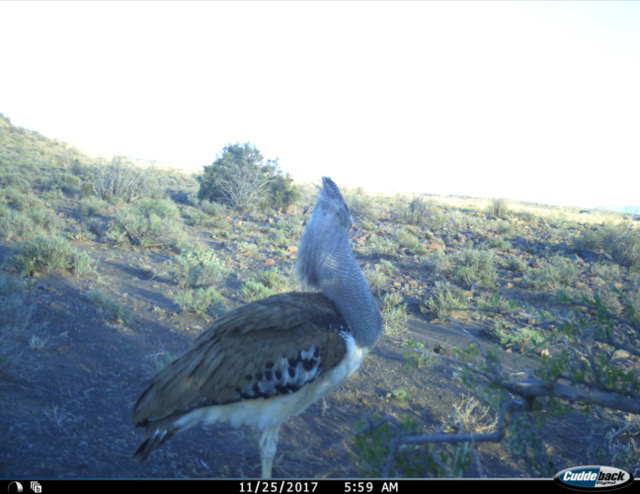

In [4]:
sample_im_file = './data/bustardkori/KAR_S1_D03_R1_IMAG0111.JPG'
# Load the image using the viz_utils tools
sample_image = viz_utils.load_image(sample_im_file)
# Show the image
sample_image

Now you can use the megadetector to detect and classify the object in the image. You are only interested in animals (category=1). The model can detect more than one object in the image. All those detections are stored in a list called `detections`. Run the next cell to see the MegaDetector in action:

In [5]:
# Run MegaDetector on a single image
megadetector_result = megadetector.generate_detections_one_image(sample_image, sample_im_file, detection_threshold=0.6)
print(megadetector_result)

{'file': './data/bustardkori/KAR_S1_D03_R1_IMAG0111.JPG', 'max_detection_conf': 0.968, 'detections': [{'category': '1', 'conf': 0.968, 'bbox': [0.1999, 0.3542, 0.4015, 0.6153]}]}


The resulting output has several fields:

- `file`: the relative path of the input picture.
- `max_detection_conf`: The confidence value of the object that the model is most certain about.
- `detections`: A list containing all detected objects in the picture which confidence is higher than the detection_threshold (0.6 in the examples)

The structure of each detection is the following:

- `category`: A string containing the id of the category. ('1': 'animal', '2': 'human', '3': 'vehicle' )
- `conf`: Confidence in the labeling of this detection
- `bbox`: A list of 4 values describing the box that contains the detected object(`[x, y, box_width, box_height]`). `x` and `box_width` are percentages of the image width; `y` and `box_height` are percentages of the image height. To transform those values into pixels you must multiply them by the corresponding image `width` and `height` (in pixels).

<div>
<img src="img/detection_example.jpg" width="500"/>
</div>

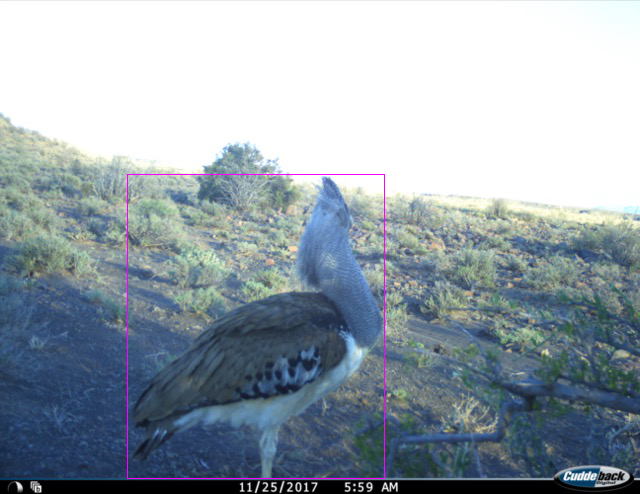

In [6]:
# Use the MegaDetector result to draw the bounding box on the image
utils2.draw_bounding_box(sample_image, megadetector_result)

### 2.2 Explore MegaDetector results for different images

You can now look at some examples. First, you will look at random examples. In the cell below, you will open an image and run it through the MegaDetector. Then you will show the image and draw bounding boxes around the identified animals.

In [7]:
# Create a list of example images
examples = list(glob.iglob(f'./data/**/*.JPG', recursive=True))
print('List of example images created')

List of example images created


Now you can select a random image from the list of examples. Then use MegaDetector for detecting the animal, and show the result in the image. You can run this cell several times to see different images.

{'file': './data/springbok/KAR_S1_B02_R1_IMAG1084.JPG', 'max_detection_conf': 0.939, 'detections': [{'category': '1', 'conf': 0.939, 'bbox': [0, 0.1518, 0.275, 0.3927]}]}


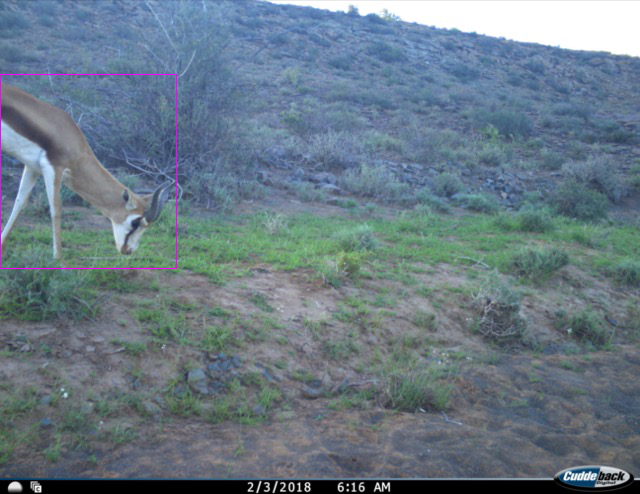

In [8]:
# Grab a random image and run MegaDetector on it
random_im_file = choice(examples)
random_image = viz_utils.load_image(random_im_file)
random_megadetector_result = megadetector.generate_detections_one_image(random_image, random_im_file, detection_threshold=0.6)
print(random_megadetector_result)
utils2.draw_bounding_box(random_image, random_megadetector_result)

{'file': './data/gemsbokoryx/KAR_S1_A01_R1_IMAG00291.JPG', 'max_detection_conf': 0.934, 'detections': [{'category': '1', 'conf': 0.731, 'bbox': [0.7984, 0.4291, 0.1046, 0.08906]}, {'category': '1', 'conf': 0.885, 'bbox': [0.4171, 0.3846, 0.1109, 0.1315]}, {'category': '1', 'conf': 0.934, 'bbox': [0.6718, 0.2368, 0.2249, 0.3319]}]}


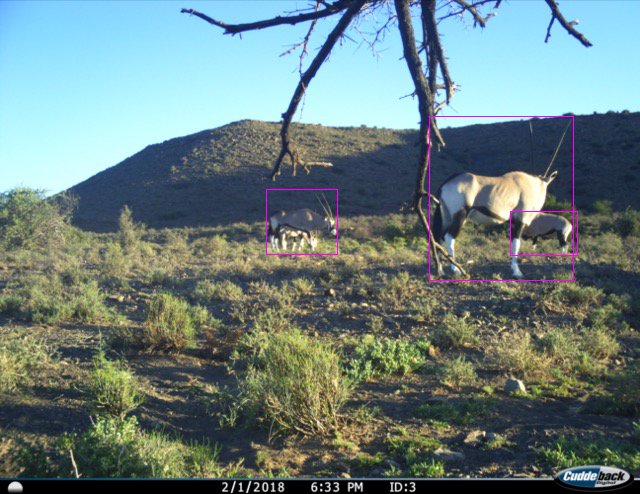

In [9]:
# Run the MegaDetector on an image with multiple detections
example_im_file = './data/gemsbokoryx/KAR_S1_A01_R1_IMAG00291.JPG'
example_image = viz_utils.load_image(example_im_file)
example_megadetector_result = megadetector.generate_detections_one_image(example_image, example_im_file, detection_threshold=0.6)
print(example_megadetector_result)
utils2.draw_bounding_box(example_image, example_megadetector_result)

## 3. Crop and square images

Your goal in using MegaDetector is to identify where animals appear in images and crop out the region inside the bounding box (you'll see what this means and how the image would look when you run the cell in Section 4 of this notebook). Ultimately, you will use these cropped images to train another model to classify the animals. As you will have noticed, the bounding boxes come in all shapes and sizes, but in order to use these cropped images for training, you'll need them to all be the same shape and size. 

The model that you are going to use for classification requires square images of 244x244 pixels. So, before cropping the images, the width and height of the bounding boxes must be fixed. The process consists in increasing the shorter side to match the larger. This could lead to cases when the squared bounding box(green) falls outside the image. In such cases we fill that part with zeros (color black).

<img src='img/bbox.png' width=600>

## 4. Use MegaDetector Output for Cropping the Region of Interest

The following functions crop the region of interest in an image using the MegaDetector output, and save the cropped image into the specified subfolder. We will use this to build our dataset. This process can be described as:

- Detect the regions of interest using the MegaDetector
- Square the regions
- Crop the squared regions
- Resize the cropped images to 244x244 pixels
- Save the result to the file system

Megadetector output:
{'file': './data/bustardkori/KAR_S1_D03_R1_IMAG0114.JPG', 'max_detection_conf': 0.966, 'detections': [{'category': '1', 'conf': 0.966, 'bbox': [0.1968, 0.4554, 0.4406, 0.5121]}]}

Detected animals:
{'category': '1', 'conf': 0.966, 'bbox': [0.1968, 0.4554, 0.4406, 0.5121]}


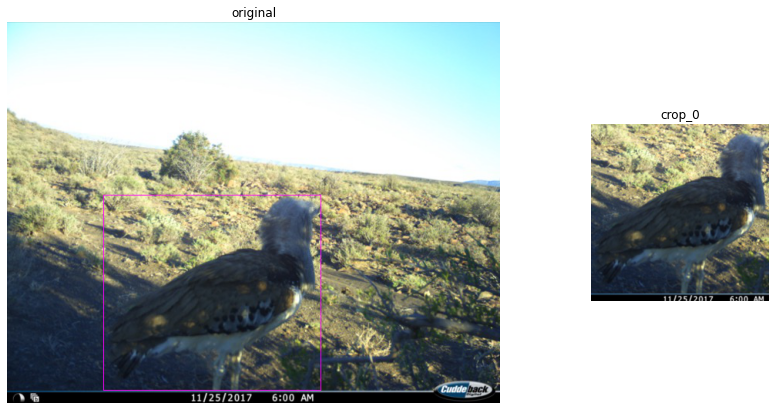

In [10]:
%matplotlib inline
# Choose a random file path
random_im_file = choice(examples)
# Load the image
random_image = viz_utils.load_image(random_im_file)
# Detect animals using megadetector and crop the detected areas
res = megadetector.generate_detections_one_image(random_image, random_im_file, detection_threshold=0.6)
print(f"Megadetector output:\n{res}\n\nDetected animals:")
animals = utils2.crop_image(random_image, res, './data','/tmp')

# Plot the image with bounding boxes and cropped images
utils2.plot_detections(random_image, animals, res)

## 5. Process the Dataset

Run the next cell to use the MegaDetector for cropping the images and storing the result for use in the next exercise.

In [11]:
root_dir = './data'
utils2.preprocess_dataset(root_dir, megadetector, utils2.crop_image, 0.6, 0)
print('Images processed successfully')

Images processed successfully


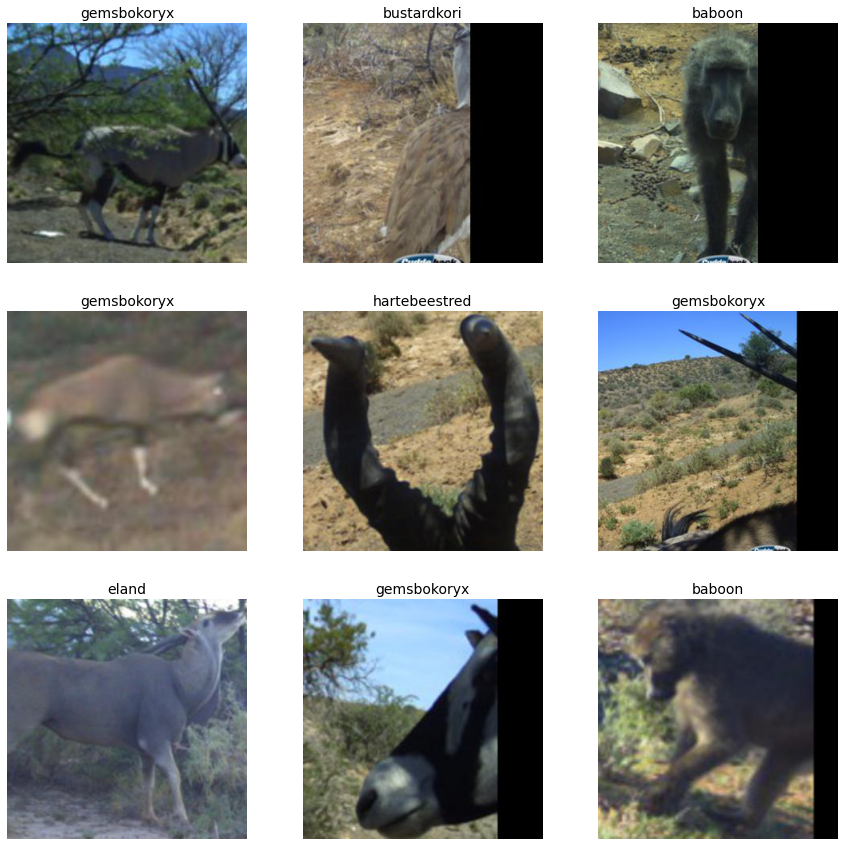

In [12]:
# Plot a random set of the cropped images
utils2.plot_cropped_images()

## **Congratulations on finishing this lab!**

**Keep up the good work :)**